In [127]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from django.db.models import Count, Avg, F, Sum
import math

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from utils.utils import ars

qid = 1558
q = Query.objects.get(pk=qid)


In [242]:

p = Project.objects.get(title="NETs")
pdocs = Doc.objects.filter(query__project=p)

techs = Technology.objects.filter(project=p).exclude(name__in=["Bioenergy","Storage"])
#techs = Technology.objects.filter(project=p)


trdocs = set(list(pdocs.filter(
    docownership__relevant=1,
    docownership__query__technology__in=techs
).values_list('UT',flat=True)))

ttdocs = set(list(Doc.objects.filter(
    technology__in=techs
).values_list('UT',flat=True)))

In [248]:
print(len(trdocs))
print(len(ttdocs))

allreldocs =  Doc.objects.filter(
    UT__in=trdocs.union(ttdocs)
)

print(allreldocs.count())

print(allreldocs.order_by('PY').first().PY)
print(allreldocs.order_by('PY').first().title)

print(allreldocs.filter(PY__lt=1990).count())

1804
257
1994
1977
Production of synthetic methanol from air and water using controlled thermonuclear reactor power-I. technology and energy requirement
3


In [201]:
qdocs = Doc.objects.filter(query=q)
ard_ids = allreldocs.values_list('UT',flat=True)

badocs = qdocs.exclude(UT__in=ard_ids)

badocs[0].query.all()

<QuerySet [<Query: scopus_all>, <Query: climate_all>, <Query: CCS storage_scopus>, <Query: ccs storage_both>, <Query: CCS storage>, <Query: ccs storage final both>, <Query: NETS_all_relevant>, <Query: NETS_scopus>, <Query: NETS_scopus_retry_y2>]>

In [204]:
doc_dict = []

ts = Technology.objects.filter(
    project=p
).exclude(
    name__in=['Bioenergy','Ethics & Morals']
)

#allreldocs = Doc.objects.filter(query=q)
pys = list(range(1990,2017))
for t in ts:
    for py in pys:
        ydocs = allreldocs.filter(PY=py)
        trdocs = set(list(ydocs.filter(
            query__technology=t,docownership__relevant=1,docownership__query__technology=t
        ).values_list('UT',flat=True)))
        ttdocs = set(list(ydocs.filter(
            technology=t
        ).values_list('UT',flat=True)))
        tdocs = Doc.objects.filter(
            UT__in=trdocs.union(ttdocs)
        )
        d = {
            'Technology': t.name,
            'PY': py,
            'n': tdocs.count()
        }
        doc_dict.append(d)

In [205]:
df = pd.DataFrame.from_dict(doc_dict)

techorder = list(Technology.objects.filter(project=p).order_by('-ndocs').values_list('name',flat=True))


df['Technology'] = pd.Categorical(
    df['Technology'],
    techorder
)

df.head()

,PY,Technology,n
0,1990,Enhanced Weathering,0
1,1991,Enhanced Weathering,0
2,1992,Enhanced Weathering,0
3,1993,Enhanced Weathering,0
4,1994,Enhanced Weathering,0


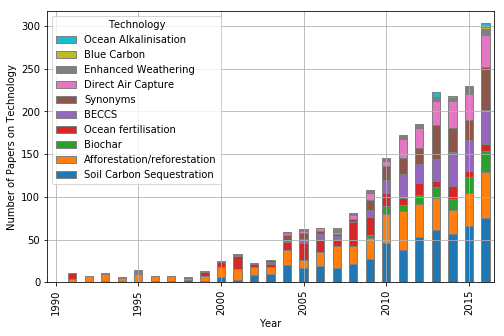

In [229]:
plt.rcParams["figure.figsize"] = [8,5]

pdf = df.pivot(
    index='PY',
    columns='Technology',
    values='n'
)

fig, ax = plt.subplots()


pdf.plot.bar(
    stacked=True, 
    ax=ax,
    legend=False,    
    lw=1,
    edgecolor='grey'
)

handles, labels = ax.get_legend_handles_labels()
#lpos = (0.85,2.5)

#ax.locator_params(nbins=10, axis='x')
#ax.tick_params(direction='out', length=6, width=2, colors='r',axis='x')

ax.xaxis.set_ticks([0,5,10,15,20,25])
ax.xaxis.set_ticklabels([1990,1995,2000,2005,2010,2015])

ax.legend(handles[::-1], labels[::-1],title='Technology')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Papers on Technology')

ax.grid(True)

plt.savefig('plots/general/by_tech.png',bbox_inches='tight') 

plt.show()



In [230]:
tsums = []

for name, group in df.groupby('Technology'):
    gsum = group['n'].sum()
    try:
        g11 = int(group[group['PY']==2011]['n'])
    except:
        g11 = 0
    try:
        g16 = int(group[group['PY']==2016]['n'])
    except:
        g16 = 0
    growth = g16 - g11
    try:
        cagr = (math.pow((g16/g11),(1/5))-1)*100
    except:
        cagr = np.NaN
    tsum = {
        'Technology': name,
        'Sum': gsum,
        '5year_compound_annual_growth_16': cagr 
    }
    tsums.append(tsum)
    
tsummary = pd.DataFrame.from_dict(tsums)

tsummary = tsummary[tsummary['Sum']>0].sort_values('Sum',ascending=False)

tsummary.to_excel('tables/tech_totals.xlsx')

tsummary.head(15)



,5year_compound_annual_growth_16,Sum,Technology
0,14.565943,554,Soil Carbon Sequestration
1,3.258827,487,Afforestation/reforestation
4,7.394092,237,BECCS
5,21.350978,231,Synonyms
3,-2.328132,218,Ocean fertilisation
6,11.550670,206,Direct Air Capture
2,33.032500,99,Biochar
7,14.869835,39,Enhanced Weathering
11,NaN,20,Ocean Alkalinisation
8,8.447177,12,Blue Carbon


In [207]:
df.to_excel('tables/tech_year_totals.xlsx')

In [208]:
bypy = allreldocs.filter(
       PY__in=range(1989,2017)
).values('PY').annotate(
    n = Count('UT', distinct=True)
).order_by('PY')

for py in bypy:
    for ar in ars:
        if py['PY'] in ar['years']:
            py['ar'] = ar['n']
            py['ar_name'] = ar['name']

bypy = pd.DataFrame.from_dict(list(bypy))

bypy.head()

bypy.tail()

,PY,ar,ar_name,n
22,2012,5,AR5,163
23,2013,5,AR5,190
24,2014,6,AR6,196
25,2015,6,AR6,215
26,2016,6,AR6,264


AR1
AR2
AR3
AR4
AR5
AR6


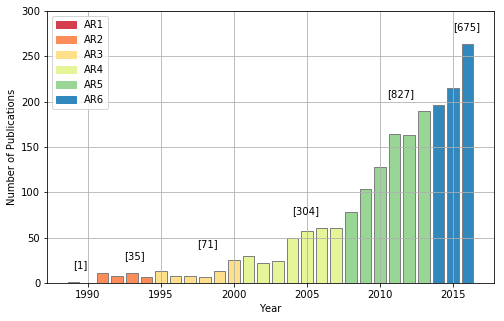

In [241]:
import matplotlib.patches as mpatches

pdf = bypy.set_index('PY')
colors = {
    0:'#8dd3c7', 
    1: '#d53e4f', 
    2: '#fc8d59', 
    3: '#fee08b', 
    4: '#e6f598', 
    5: '#99d594', 
    6: '#3288bd'
}

#d53e4f
#fc8d59
#fee08b
#e6f598
#99d594
#3288bd

#pdf['n'].plot.bar(color=[colors[int(x)] for x in list(pdf['ar'])])

fig, ax = plt.subplots()

ax.grid(True)

ax.bar(
    bypy.PY,
    bypy.n, 
    lw=1,
    edgecolor='grey',
    color=[colors[int(x)] for x in list(pdf['ar'])] 
)

handles = []
labels = []
for name, group in bypy.groupby('ar_name'):
    print(name)
    count = "[{}]".format(group['n'].sum())
    mid = group['PY'].median()
    maxn = group['n'].max() + 15
    ax.text(mid,maxn,count)
    ar = group['ar'].max()
    handles.append(mpatches.Patch(color=colors[ar], label=name))
    
plt.legend(handles=handles)
    
plt.ylim(ymax=300) 

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications')
plt.savefig('plots/general/all.png',bbox_inches='tight') 
plt.show()

In [138]:
ars

[{'n': 0, 'name': 'AR0', 'years': range(0, 1985)},
 {'n': 1, 'name': 'AR1', 'years': range(1985, 1991)},
 {'n': 2, 'name': 'AR2', 'years': range(1991, 1995)},
 {'n': 3, 'name': 'AR3', 'years': range(1995, 2001)},
 {'n': 4, 'name': 'AR4', 'years': range(2001, 2008)},
 {'n': 5, 'name': 'AR5', 'years': range(2008, 2014)},
 {'n': 6, 'name': 'AR6', 'years': range(2014, 9999)}]

[]

In [219]:
plt.get_cmap('Spectral')


AttributeError: 'LinearSegmentedColormap' object has no attribute 'values'